In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Loading the dataset
df = pd.read_csv('city_day.csv')
# Converting 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
# Displaying the first few rows of the dataframe
print(df.head())

        City       Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad 2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad 2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad 2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad 2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad 2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN  


In [4]:
!pip install geopy

** chat gpt for collecting lat lon data **

In [25]:
from geopy.geocoders import Nominatim
import time

# Initialize geocoder
geolocator = Nominatim(user_agent="geoapi")

# Example: Get coordinates of a city
location = geolocator.geocode("New York City")

print((location.latitude, location.longitude))

def get_coords(city):
    try:
        location = geolocator.geocode(city)
        return (location.latitude, location.longitude)
    except:
        print(f"Could not geocode city: {city}")
        return (None, None)

# Step 1: Get unique cities
unique_cities = df["City"].unique()

# Step 2: Geocode each unique city (with delay to avoid rate-limit issues)
city_coords = {}
for city in unique_cities:
    latlon = get_coords(city)
    city_coords[city] = latlon
    time.sleep(1)  # respect API rate limit

# Step 3: Map coordinates back to DataFrame
df[["lat", "lon"]] = df["City"].map(city_coords).apply(pd.Series)

print(df.head())


(40.7127281, -74.0060152)
        City       Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad 2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad 2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad 2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad 2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad 2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket        lat        lon  
0  133.36     0.00     0.02    0.00  NaN        NaN  23.021537  72.580057  
1   34.06     3.68     5.50    3.77  NaN        NaN  23.021537  72.580057  
2   30.70     6.80    16.40    2.25  NaN        NaN  23.021537  72.580057  
3   36.08     4.43    10.14    1.00  NaN        NaN  23.021537  72.580057  
4   39.31     7.01    18.89    2.78  NaN        NaN  23.021537  72.580057  


In [33]:
!pip install geopandas geodatasets

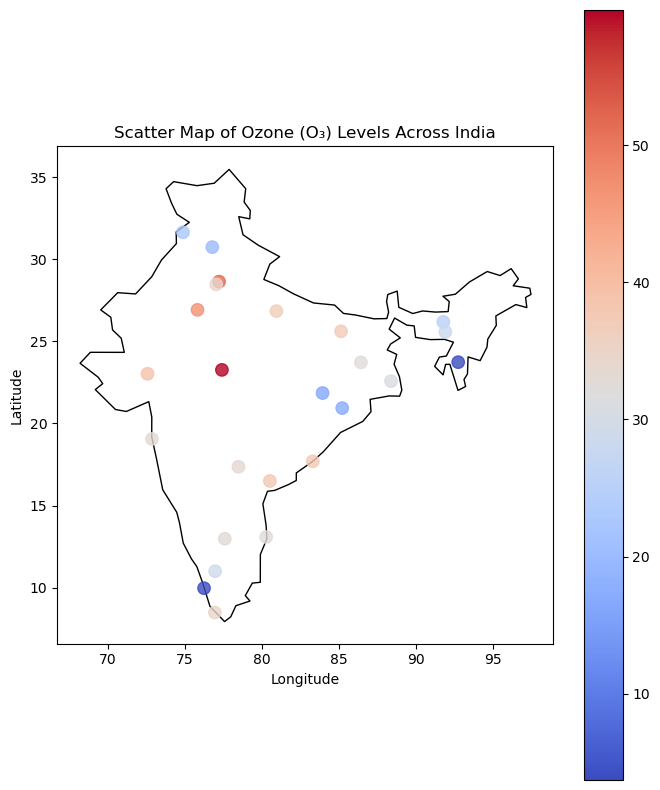

In [40]:
import geopandas as gpd

# Load Natural Earth countries (1:110m resolution)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

# Filter for India
india = world[world["ADMIN"] == "India"]


# groups by city and takes mean of O3 values
df_mean = df.groupby(['City']).mean('O3').reset_index()
# Remove rows with NaN values in or 'O3' columns
df_clean = df_mean.dropna(subset=["O3"])

gdf = gpd.GeoDataFrame(
    df_clean,  # remove NaNs
    geometry=gpd.points_from_xy(df_clean["lon"], df_clean["lat"]),
    crs="EPSG:4326"
)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 10))
india.plot(ax=ax, color="white", edgecolor="black")  # India boundary

# Scatter plot of O3 levels
gdf.plot(
    ax=ax,
    column="O3",        # pollutant column
    cmap="coolwarm",        # color scheme
    markersize=80,      # adjust dot size
    alpha=0.8,
    legend=True
)

plt.title("Scatter Map of Ozone (O₃) Levels Across India")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [12]:
!pip install folium

** chat gpt map for future reference **

open saved html file using browser for interactive map.

In [ ]:
import folium
from folium.plugins import HeatMap

# Create base map centered on India
m = folium.Map(location=[22.9734, 78.6569], zoom_start=5, tiles="cartodbpositron")

# Add heatmap

# groups by city and takes mean of O3 values
df_mean = df.groupby(['City']).mean('O3').reset_index()
# Remove rows with NaN values in or 'O3' columns
df_clean = df_mean.dropna(subset=["O3"])

# converts to list for folium heatma to plot
heat_data = df_clean[["lat", "lon", "O3"]].values.tolist()
HeatMap(heat_data, radius=25, blur=15, max_zoom=6).add_to(m)

# Save map to HTML
m.save("india_pollution_heatmap.html")


<Axes: xlabel='Date', ylabel='O3'>

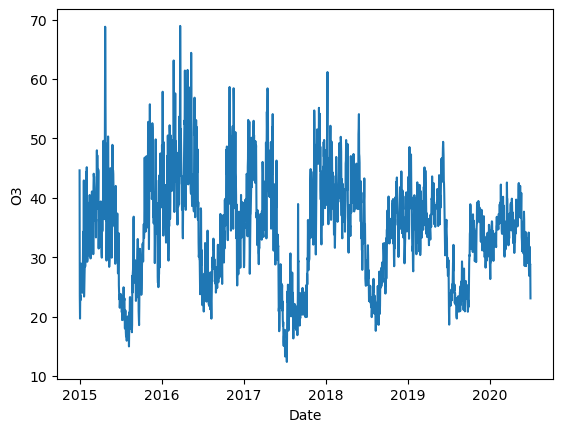

In [ ]:
# Calculating mean ozone levels per day across all cities
df_mean = df.groupby(['Date']).mean('O3').reset_index()
# plotting mean indian ozone levels over time
sns.lineplot(data = df_mean , x = 'Date', y = 'O3')

Correlation matrix for pollutants across all cities and days.

<Axes: >

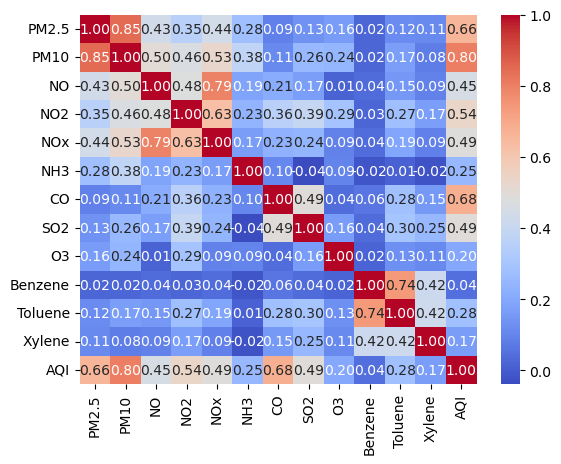

In [ ]:
# Correlation matrix for pollutants.
df_corr = df.drop(['AQI_Bucket', 'City', 'Date'], axis=1)
corr_matrix = df_corr.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')